# XGBoost -set A training, B testing and C for scoring

In [155]:
#importing libraries
from modules.pca_module import perform_pca
from modules.data_preprocessing import one_hot_encode_categorical
import numpy as np
import pandas as pd
import xgboost as xgb
from numpy import array  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve, auc, make_scorer, precision_score, recall_score, fbeta_score,  average_precision_score
from urllib.request import urlretrieve
import glob
from pathlib import Path  # Importing the Path class from the pathlib module
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os 
import math
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE, RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler


In [156]:
SEED = 123
RANDOM_STATE = 42
def seed_everything(seed=SEED):
    """
    Set the random seed for Python, NumPy, and random module.

    Parameters:
    - seed (int): The seed value to set for randomness. Defaults to 42.

    Returns:
    - None
    """
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)

In [157]:
#GLOBAL VARIABLES
#define percentage of test_split
test_size = 0.2
# Define the programmer whose path you want to use
programmer = 'esther'

#variables for paths names
file_paths_names = {
    'patricia': r"..\original_data",
    'esther': r"C:\Users\egh22\OneDrive - University of Canterbury\bootcamp\group project\data"
}

files_outcome_path_names = {
    'patricia': r"C:\PATRICIA\CODEOP\aaa-PROYECTO COMPARTIDO\ICU-MORTALITY-PREDICTION\original_data\outcomes",
    'esther': r"C:\Users\egh22\OneDrive - University of Canterbury\bootcamp\group project\data\outcomes"
}

#TODO: patricia to add his path properly
files_path_to_save_files = {
    'patricia': r"C:\PATRICIA\CODEOP\aaa-PROYECTO COMPARTIDO\ICU-MORTALITY-PREDICTION",
    'esther': r"C:\Users\egh22\OneDrive - University of Canterbury\bootcamp\group project\clean_data\withsetc"
}

# Choose the file path based on the programmer variable
file_path_to_save = files_path_to_save_files[programmer]
file_path_to_open = file_path_to_save


In [158]:
#modify this with the name of the paths to read
files_outcome_path =  files_outcome_path_names[programmer]
outcomes_a = pd.read_csv(Path(files_outcome_path) / "Outcomes-a.txt")
outcomes_b = pd.read_csv(Path(files_outcome_path) / "Outcomes-b.txt")
outcomes_c = pd.read_csv(Path(files_outcome_path) / "Outcomes-c.txt")

outcomes_a = outcomes_a.drop(columns=['SOFA', 'SAPS-I', 'Survival'])
outcomes_b = outcomes_b.drop(columns=['SOFA', 'SAPS-I', 'Survival'])
outcomes_c = outcomes_c.drop(columns=['SOFA', 'SAPS-I', 'Survival'])

### 1. Look at the distribution of the target variable

In [159]:
#loading dataframe for plottin distirbution
knn_df = pd.read_csv(os.path.join(file_path_to_save, 'KNN_imputed_df.csv')) 

In [160]:
# counting positive and negative samples
knn_df['In-hospital_death'].value_counts()
num_pos_samples = knn_df['In-hospital_death'].value_counts()[1]
num_neg_samples  = knn_df['In-hospital_death'].value_counts()[0]
print("Number of positive samples for in hospital death:", num_pos_samples)
print("Number of negative samples for in hospital death:", num_neg_samples)

Number of positive samples for in hospital death: 1707
Number of negative samples for in hospital death: 10293


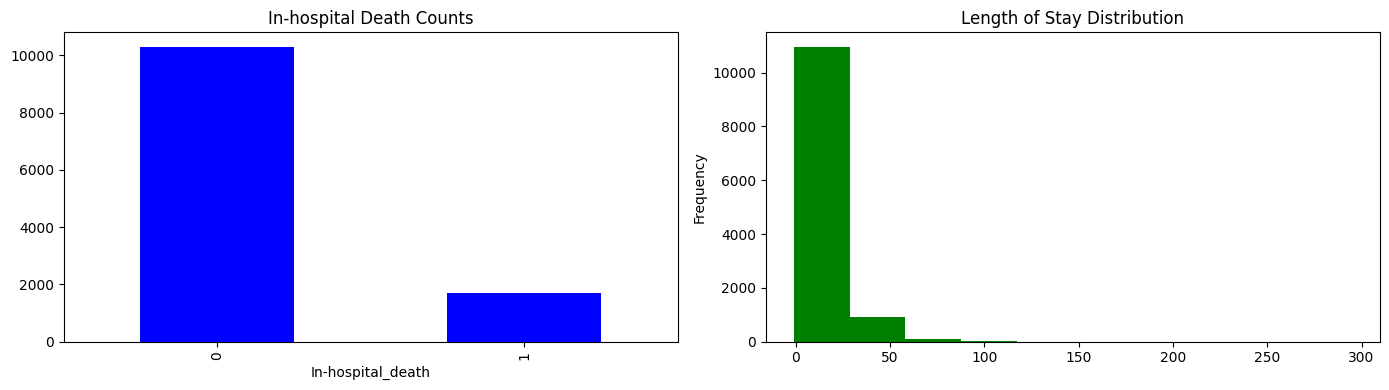

In [161]:
# Create a new figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(14, 4))  # 1 row, 2 columns for two plots

# Plot the count of each value in the 'In-hospital_death' column as a bar plot
knn_df['In-hospital_death'].value_counts().plot(kind="bar", ax=axs[0], color='blue')

# Plot the distribution of values in the 'Length_of_stay' column as a histogram
knn_df['Length_of_stay'].plot(kind="hist", ax=axs[1], color='green')

# Set titles for each subplot
axs[0].set_title('In-hospital Death Counts')
axs[1].set_title('Length of Stay Distribution')

# Show the plots
plt.tight_layout()
plt.show()

## 2. XGBoost Modelling - In Hospital death prediction

<b> Some XGBoost Theory for classification problems </b> </br> </br>
Using XGBClassifier() in combination with RandomizedSearchCV or GridSearchCV is a common approach for hyperparameter tuning and model selection. RandomizedSearchCV, samples from a distribution of parameters, and GridSearchCV evaluates all possible combinations of hyperparameters provided in a grid.

When tuning XGBoost models for classification tasks, there are several important parameters to consider. Here are some of the most crucial ones:

- Learning Rate (eta): The learning rate controls the step size during the gradient descent optimization process. Lower values typically result in slower learning but can lead to better generalization.

- Maximum Depth (max_depth): How deeply a tree is allowed to grow during each boosting round.  Deeper trees can capture more complex patterns in the data but are more prone to overfitting.

- Minimum Child Weight (min_child_weight): This parameter specifies the minimum sum of instance weight needed in a child node. It helps to control overfitting by constraining the partitioning of leaf nodes.

- Subsample:Subsample controls the fraction of training data to be used for each boosting round. If the value is low we can run into underfitting, if the value is very high we may run into overfitting.
  
- Column Subsampling (colsample_bytree or colsample_bylevel): These parameters control the fraction of features (columns) to be used for each tree or each level of trees, respectively during any boosting round. a large value means that almost all features can be used to build a tree during every boosting round. In general a small value can be thought as providing additional regularization to the model, using all columns may overfit a training model. They help introduce diversity into the ensemble and reduce overfitting. As a thumb-rule, square root of the total number of features works great but we should check upto 30-40% of the total number of features.

- Regularization Parameters (lambda, alpha):
Lambda (L2 regularization) and alpha (L1 regularization) control the amount of regularization applied to the weights of the trees. They help prevent overfitting by penalizing large parameter values.

- Number of Trees (num_boost_round):
This parameter specifies the maximum number of boosting rounds (trees) to be trained. Increasing the number of trees can improve performance, but it's essential to monitor for overfitting.

Early Stopping (early_stopping_rounds): Early stopping allows training to stop if the performance on a validation dataset does not improve for a specified number of rounds. It helps prevent overfitting and reduces training time.

Objective Function: The choice of objective function depends on the specific classification problem (e.g., binary classification, multiclass classification). Common options include binary logistic regression (binary classification) and softmax (multiclass classification).

Scale Pos Weight: This parameter is used to balance the positive and negative weights in binary classification tasks with imbalanced class distributions.

A thought on metrics
To evaluate the model I think the best is to us PR AUC (precision-recall curve):
What we are going to use though as a metric is precision and recall, and we will find the minimum of both of them, and this will be our metric as we want both of those metrics to be high

In [162]:
def find_optimal_boosting_rounds(X_train, y_train, X_test, y_test, boosting_training_parameters, eval_metric, early_stopping_rounds=20, n_estimators=1000):
    """
    Find the optimal number of boosting rounds for an XGBoost classifier with specified parameters.

    Parameters:
    X_train (array-like): Training input samples.
    y_train (array-like): Target values for training.
    X_test (array-like): Testing input samples.
    y_test (array-like): Target values for testing.
    training_parameters (dict): Parameters for XGBoost classifier.
    eval_metric (str): Evaluation metric.
    early_stopping_rounds (int): Number of early stopping rounds (default is 20).
    n_estimators (int): Number of boosting rounds (default is 1000).
    

    Returns:
    optimal_boosting_rounds (int): Optimal number of boosting rounds.
    """


    # Create XGBClassifier instance
    xgb_classifier  = xgb.XGBClassifier(n_jobs=-1, enable_categorical=True,
                                        objective = "binary:logistic",
                                        eval_metric = eval_metric,
                                        early_stopping_rounds = early_stopping_rounds,
                                        n_estimators = n_estimators,
                                        **boosting_training_parameters)

    # Train with early stopping
    xgb_classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    # Get the optimal number of boosting rounds
    optimal_boosting_rounds = xgb_classifier.best_iteration
    print("Optimal number of boosting rounds:", optimal_boosting_rounds)

    return optimal_boosting_rounds

In [163]:
def perform_xgb_grid_search(X_train, y_train, gbm_param_grid, fone_scorer, optimal_boosting_rounds, eval_metric, method_name, cross_validation_folds=5):
    """
    Perform grid search with XGBoost classifier to find the best parameter combination.

    Parameters:
    X_train (array-like): Training input samples.
    y_train (array-like): Target values for training.
    gbm_param_grid (dict): Grid of parameters for XGBoost classifier.
    fone_scorer (callable): Scoring function for evaluation.
    optimal_boosting_rounds (int): Number of boosting rounds.
    eval_metric (str): Evaluation metric.
    cross_validation_folds (int): Number of cross-validation folds (default is 5).

    Returns:
    results_df (DataFrame): DataFrame containing results of the grid search.
    best_params (dict): Best parameters found during grid search.
    """

    # Create XGBClassifier instance
    xgb_classifier = xgb.XGBClassifier(n_jobs=-1, 
                                       enable_categorical=True, 
                                       objective="binary:logistic", 
                                       eval_metric=eval_metric, 
                                       n_estimators=optimal_boosting_rounds)
   
    # Create a KFold cross-validator
    kf = KFold(n_splits=cross_validation_folds, shuffle=True, random_state=RANDOM_STATE)


    # Create grid search to find the best parameter combination
    xgb_grid_search = GridSearchCV(estimator=xgb_classifier, 
                                   param_grid=gbm_param_grid, 
                                   cv=kf, 
                                   scoring=fone_scorer, 
                                   verbose=1)

    # Fit all the parameter combinations to train data using cross-validation
    xgb_grid_search.fit(X_train, y_train)

    # Get the best parameters found during grid search
    best_params = xgb_grid_search.best_params_

    # Convert cv_results_ to a DataFrame
    results_df = pd.DataFrame(xgb_grid_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

    # Sort DataFrame by mean_test_score in descending order
    results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)
    
    # Rename the 'mean_test_score' column to 'validation_test_score'
    results_df.rename(columns={'mean_test_score': 'Cvalidation_test_score'}, inplace=True)
    results_df.rename(columns={'std_test_score': 'std_Cvalidation_score'}, inplace=True)

    # Create additional columns
    model_column = pd.Series(["XGBoost"] * len(results_df))  # Fill with "XGBoost" for all rows
    method_column = pd.Series([method_name] * len(results_df))  # Fill with method_name for all rows

    # Concatenate additional columns with results_df
    results_df = pd.concat([model_column.rename("Model"), method_column.rename("Method"), results_df], axis=1)

    return results_df, best_params

In [164]:
def evaluate_xgb_classifier(X_train, y_train, X_test, y_test, best_params, optimal_boosting_rounds,  method_name, eval_metric):
    """
    Create, train, evaluate, and visualize an XGBoost classifier with the best parameters.

    Parameters:
    X_train (array-like): Training input samples.
    y_train (array-like): Target values for training.
    X_test (array-like): Testing input samples.
    y_test (array-like): Target values for testing.
    best_params (dict): Best parameters found during grid search.
    optimal_boosting_rounds (int): Number of boosting rounds.
    eval_metric (str): Evaluation metric.
    model_name (str): Name of the model.

    Returns:
    best_xgb_classifier (XGBClassifier): Trained XGBoost classifier with the best parameters.
    model_results_df (DataFrame): DataFrame containing precision, recall, and F1-score of the model.
    """

    # Create XGBClassifier with the best parameters
    best_xgb_classifier = xgb.XGBClassifier(n_jobs=-1, 
                                            enable_categorical=True, 
                                            objective="binary:logistic", 
                                            eval_metric=eval_metric,
                                            **best_params, 
                                            n_estimators=optimal_boosting_rounds)

    # Fit the model with the best parameters
    best_xgb_classifier.fit(X_train, y_train)

    # Make predictions on test data
    y_pred = best_xgb_classifier.predict(X_test)

    # Get predicted probabilities for positive class
    y_probs = best_xgb_classifier.predict_proba(X_test)[:, 1]
    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    # Calculate area under the curve (AUC) for PR curve
    pr_auc = auc(recall, precision)
    
    # Calculate precision, recall, and F1-score for label 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=best_xgb_classifier.classes_)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_xgb_classifier.classes_).plot()
    plt.show()

    # Create a DataFrame with the current model's results
    model_results_df = pd.DataFrame({'Model': ['Xgcboost'], 'Method': [method_name], 'Precision': [precision], 'Recall': [recall], 'F1-Score': [f1], 'PRAUC': [pr_auc]})
    
    return best_xgb_classifier, model_results_df


In [165]:
def perform_full_xgb_workflow(X_train, y_train, X_test, y_test, boosting_training_parameters, training_parameters_grid, fone_scorer, model_name, eval_metric, early_stopping_rounds=20, n_estimators=1000, cross_validation_folds=5, resampling_technique = "None"):
    """
    Perform the full workflow including grid search, evaluation, and visualization of XGBoost classifier.

    Parameters:
    X_train (array-like): Training input samples.
    y_train (array-like): Target values for training.
    X_test (array-like): Testing input samples.
    y_test (array-like): Target values for testing.
    boosting_training_parameters (dict): Parameters for XGBoost classifier training.
    gbm_param_grid (dict): Grid of parameters for XGBoost classifier.
    fone_scorer (callable): Scoring function for evaluation.
    model_name (str): Name of the model.
    eval_metric (str): Evaluation metric (default is "aucpr").
    cross_validation_folds (int): Number of cross-validation folds (default is 5).
    resampling_technique(str): indicates type fo re-sampling technique, by default is None
    Returns:
    best_xgb_classifier (XGBClassifier): Trained XGBoost classifier with the best parameters.
    results_df (DataFrame): DataFrame containing precision, recall, and F1-score of the model.
    """

    if resampling_technique == "SMOTE" or resampling_technique == "Undersampling" or resampling_technique == "Oversampling":
        # avoid applying weighting if samples are balanced
        boosting_training_parameters['scale_pos_weight'] = 1
        training_parameters_grid['scale_pos_weight'] = [1]
    else:
        boosting_training_parameters['scale_pos_weight'] = np.sqrt(num_neg_samples / num_pos_samples)
        training_parameters_grid['scale_pos_weight'] = [np.sqrt(num_neg_samples / num_pos_samples)]
        
    print("TRainingparameterS", training_parameters_grid['scale_pos_weight'])

    # Step 1: Find optimal number of boosting rounds
    optimal_boosting_rounds = find_optimal_boosting_rounds(X_train, y_train, X_test, y_test, boosting_training_parameters, eval_metric, early_stopping_rounds, n_estimators)

    # Step 2: Perform grid search to find the best parameters
    grid_search_results_df, best_params = perform_xgb_grid_search(X_train, y_train, training_parameters_grid, fone_scorer, optimal_boosting_rounds, eval_metric, model_name, cross_validation_folds)

    # Step 3: Evaluate and visualize the XGBoost classifier
    best_xgb_classifier, model_results_df = evaluate_xgb_classifier(X_train, y_train, X_test, y_test, best_params, optimal_boosting_rounds, model_name, eval_metric)

    return best_xgb_classifier, grid_search_results_df, model_results_df

<b> Defining XGboost parameters common for all models </b>

In [166]:
# Specify your choice of split for training and testing
choice_train = '_a'  # Choose from '_a', '_b', or '_c' for training
choice_test = '_b'   # Choose from '_a', '_b', or '_c' for testing

# defining default parameters
cross_validation_folds = 5
early_stopping_rounds = 20
num_boosting_rounds = 1000
categorical_features = ['Gender', 'ICUType', 'MechVent'] 
eval_metric="aucpr"

# define Custom scorer based on f1 score that balances precision and recall
# we can use beta to define wehther we want to penalize recall or precision
fone_scorer = make_scorer(fbeta_score,
                          beta = 1,
                          greater_is_better = True,
                          pos_label = 1)

#if we want prauc
#fone_scorer = make_scorer(average_precision_score)
#TODO: Do I need this???

#Define the number of folds for cross-validation. 
#kf = KFold(n_splits=cross_validation_folds, shuffle=True, random_state=42)

#define parameter grid for tunning the algorithms
gbm_param_grid_for_tunning = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma':[1e-5, 1e-2, 0.1, 0.5],
    'reg_alpha':[1e-5, 1e-2, 0.5, 1], #used for high dimensionality
    'reg_lambda':[1e-5, 1e-2, 0.5, 1], #explore for reducing overfitting
    'max_depth': [5, 7, 9],
    'min_child_weight': [1, 5, 15, 200], #NEED HELP ON HOW TOSET UP THIS
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.5, 0.6, 0.7],
    "n_estimators":[100],
    'scale_pos_weight': [1, (num_neg_samples / num_pos_samples),np.sqrt(num_neg_samples / num_pos_samples)] #scale_pos_weight is the ratio of number of negative class to the positive class.
}

#grid fixed for parameters for XGBoost this is to allow methods for tunning but use single parameters in case the model is really bad
gbm_param_grid_for_tunning_fixed = {
    'learning_rate': [0.1],
    'max_depth': [7],
    'min_child_weight': [100],
    'gamma':[0.01],
    'reg_alpha':[0.3], #used for high dimensionality
    'reg_lambda':[0.3], #explore for reducing overfitting
    'subsample': [0.8],
    'colsample_bytree': [0.7],
    'scale_pos_weight': [np.sqrt(num_neg_samples / num_pos_samples)] #scale_pos_weight is the ratio of number of negative class to the positive class.
}


# Define parameters, we fix all other parameters and try to find best number of boosting rounds
gbm_param_for_boosting = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'min_child_weight': 100,
    'gamma':0.01,
    'reg_alpha':0.3, #used for high dimensionality
    'reg_lambda':0.3, #explore for reducing overfitting
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'scale_pos_weight': np.sqrt(num_neg_samples / num_pos_samples)
}





<b> XGBoost Models performed </b> </br> </br>
We will create a model for:
- KNN imputed dataset without PCA performed
- KNN imputed dataset with PCA performed, assuming variance explained needed of 85%
- Minus 1 imputed dataset without PCA performed
- Minus 1 imputed dataset with PCA performed, assuming variance explained needed of 85%

### 2.1 Using KNN inputed NAN file

In [167]:
#loading dataframe
knn_df = pd.read_csv(os.path.join(file_path_to_save, 'KNN_imputed_df.csv')) 

In [168]:
pd.options.display.max_columns = None
knn_df.sample()

,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,FiO2_median,FiO2_max,FiO2_mad,GCS_median,GCS_mad,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCT_median,HCT_mad,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,Lactate_median,Lactate_mad,Mg_48median,Mg_median,Mg_max,Mg_mad,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIMAP_median,NIMAP_max,NIMAP_mad,NIMAP_last,NIMAP_slope,PaCO2_median,PaCO2_max,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,Temp_median,Temp_max,Temp_mad,Temp_last,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
6658,149410.0,64.0,1,4,29.201131,1,13.5,3.703704,0.04,0.95,5.263158,0.6,1.0,16.666667,6.0,0.0,110.0,123.0,136.0,10.569106,-1.04,24.0,4.166667,42.25,2.721893,93.0,101.0,3.225806,0.045123,3.5,3.6,4.2,5.555556,0.9,11.111111,1.9,1.9,1.9,0.0,95.0,122.0,5.263158,101.0,0.09855,138.0,0.724638,0.08,97.33,112.0,12.329189,112.0,0.7265,33.0,38.0,6.060606,-0.132013,96.0,104.0,161.0,9.615385,-0.154807,7.46,0.134048,181.5,4.683196,-0.68,37.4,38.6,0.802139,38.4,140.0,360.0,28.571429,120.0,1.254765,13.15,7.224335,0.076,99.0,0.0,-6.834797e-16,3,1


In [169]:
knn_df.shape

(12000, 83)

In [170]:
# Convert the specified columns to categorical type
knn_df[categorical_features] = knn_df[categorical_features].astype("category")

<b> Preparing test-train datasets </b>
- X = training data with all features except target variable 
- y = target variable "In-hospital_death" 
- Drop "Length_of_stay" and use "RecordID"  as index 

In [171]:
# Merge knn_df with outcomes_a, outcomes_b, and outcomes_c DataFrames based on RecordID
knn_df = knn_df.drop(columns=['In-hospital_death', 'Length_of_stay'])
knn_outcomes_a_df = pd.merge(knn_df, outcomes_a, on="RecordID", how="inner")
knn_outcomes_b_df = pd.merge(knn_df, outcomes_b, on="RecordID", how="inner")
knn_outcomes_c_df = pd.merge(knn_df, outcomes_c, on="RecordID", how="inner")

In [172]:
# Extract features and target variable
# For training set X_train and y_train
X_a = knn_outcomes_a_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
y_a = knn_outcomes_a_df['In-hospital_death']

# For testing set B X_test_b and y_test_b
X_b = knn_outcomes_b_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
y_b = knn_outcomes_b_df['In-hospital_death']

# For testing set C X_test_c and y_test_c
X_c = knn_outcomes_c_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
y_c = knn_outcomes_c_df['In-hospital_death']

# Define a dictionary to store the splits
data_splits = {'_a': (X_a, y_a), '_b': (X_b, y_b), '_c': (X_c, y_c)}

# Get the selected splits for training and testing
X_train, y_train = data_splits[choice_train]
X_test, y_test = data_splits[choice_test]

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)




X_train shape: (4000, 80)
X_test shape: (4000, 80)
y_train shape: (4000,)
y_test shape: (4000,)


### 2.1.1 XgBooSt performed Without PCA 

TRainingparameterS [2.4555807820458484]
Optimal number of boosting rounds: 53
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3432
           1       0.51      0.44      0.47       568

    accuracy                           0.86      4000
   macro avg       0.71      0.69      0.70      4000
weighted avg       0.85      0.86      0.86      4000



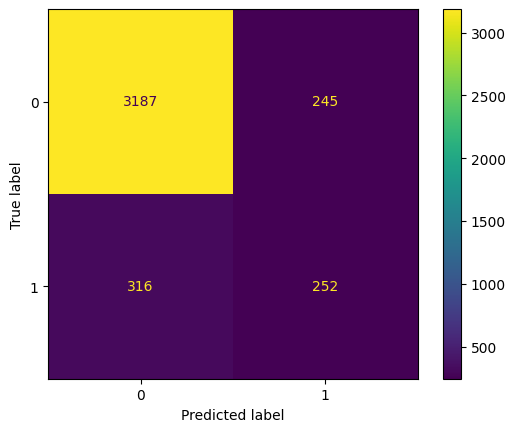

In [173]:
# run emthod to perfrom xgb workflow
model_name = "knn_df"
best_xgb_classifier, grid_search_results_df, model_results_df = perform_full_xgb_workflow(X_train, y_train, X_test, y_test, gbm_param_for_boosting, gbm_param_grid_for_tunning_fixed, fone_scorer, model_name, eval_metric, early_stopping_rounds=early_stopping_rounds, n_estimators=num_boosting_rounds, cross_validation_folds=cross_validation_folds)
all_results_df = model_results_df
all_grid_results_df  = grid_search_results_df

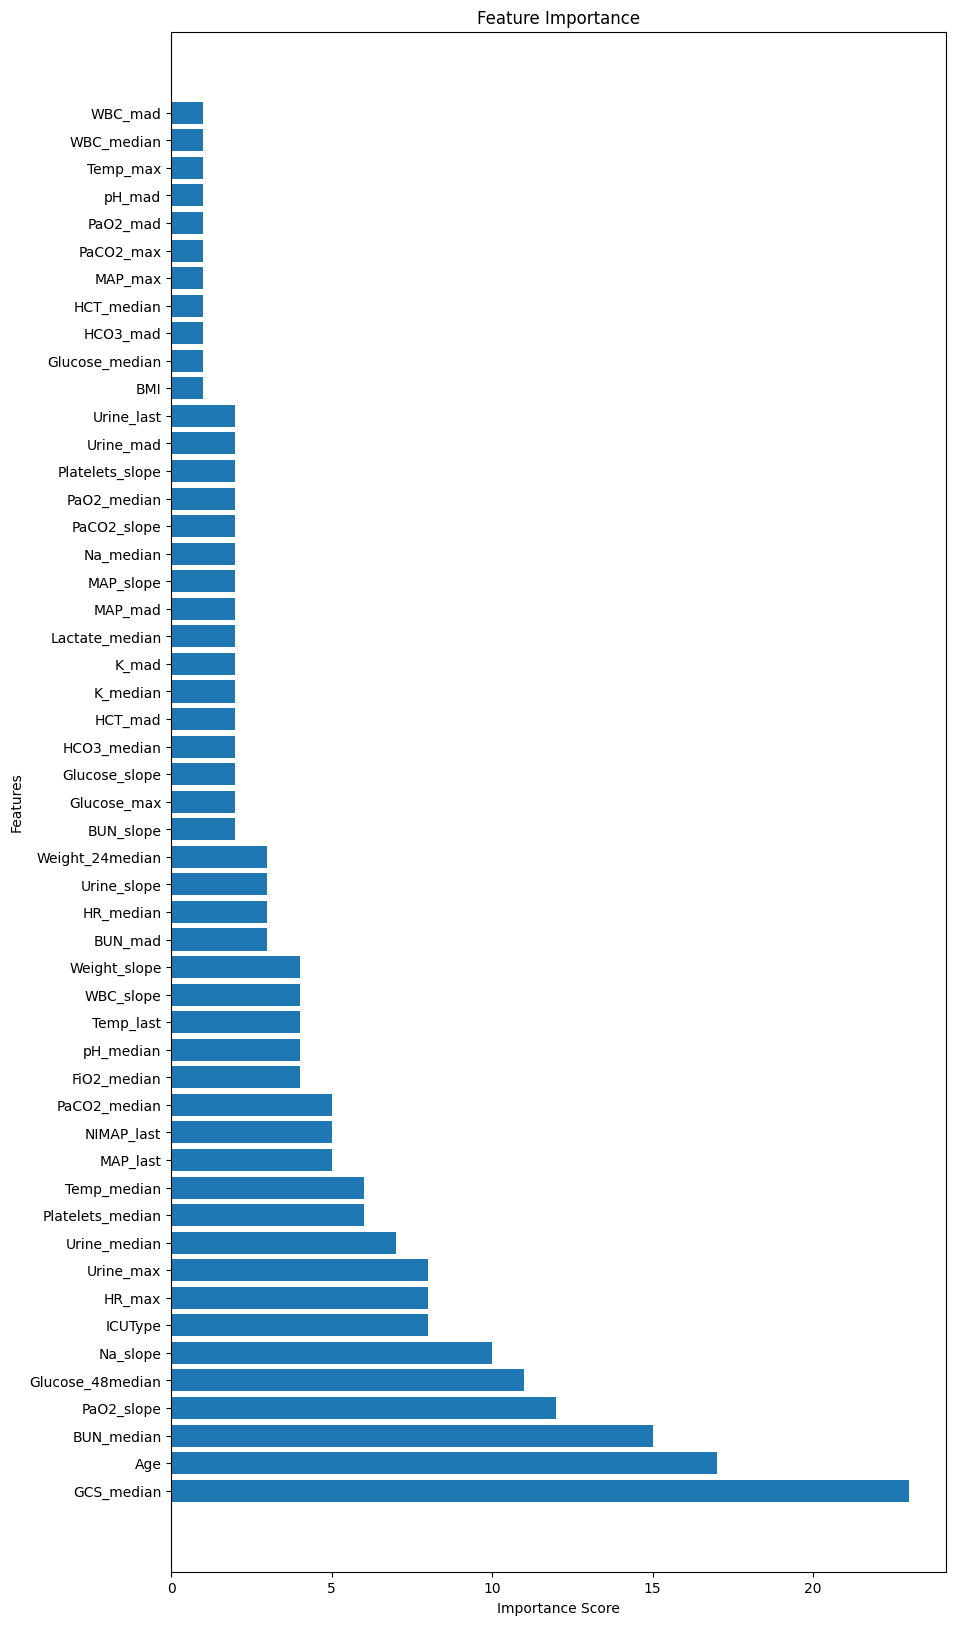

In [174]:
# Get feature importance
feature_importance = best_xgb_classifier.get_booster().get_score(importance_type='weight') 

# Plot feature importance
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
features, importance = zip(*sorted_feature_importance)

plt.figure(figsize=(10, 20))
plt.barh(range(len(features)), importance, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()


### 2.1.2 XgBooSt performed With PCA 

<b> Perform PCA </b>

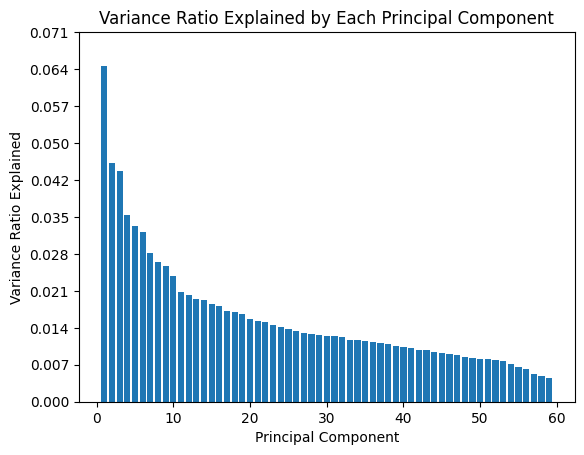

Number of components required to achieve 0.95 variance explained: 59


In [175]:
X_train_PCA, X_test_PCA, pca, explained_variance_ratio = perform_pca (X_train, X_test, categorical_features, 0.95)

TRainingparameterS [2.4555807820458484]
Optimal number of boosting rounds: 208
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      3432
           1       0.48      0.44      0.46       568

    accuracy                           0.85      4000
   macro avg       0.69      0.68      0.69      4000
weighted avg       0.85      0.85      0.85      4000



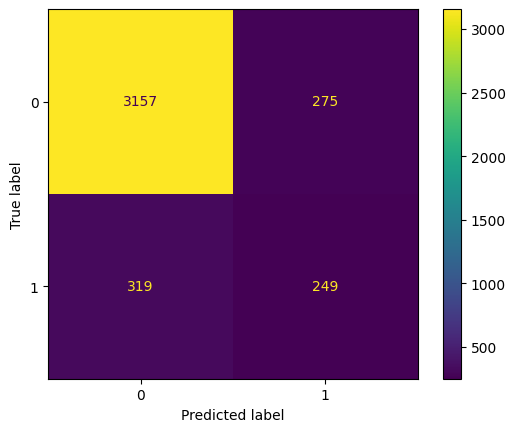

In [176]:
# run method to perfrom xgb workflow
model_name = "PCA_knn_df"
best_xgb_classifier, grid_search_results_df, model_results_df = perform_full_xgb_workflow(X_train_PCA, y_train, X_test_PCA, y_test, gbm_param_for_boosting, gbm_param_grid_for_tunning_fixed, fone_scorer, model_name, eval_metric, early_stopping_rounds=early_stopping_rounds, n_estimators=num_boosting_rounds, cross_validation_folds=cross_validation_folds)
all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)


### 2.1.3 XgBooSt performed With SMOTE

In [177]:
#permorm SMOTE
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors = 5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

TRainingparameterS [1]
Optimal number of boosting rounds: 133
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      3432
           1       0.49      0.38      0.43       568

    accuracy                           0.86      4000
   macro avg       0.69      0.66      0.67      4000
weighted avg       0.84      0.86      0.85      4000



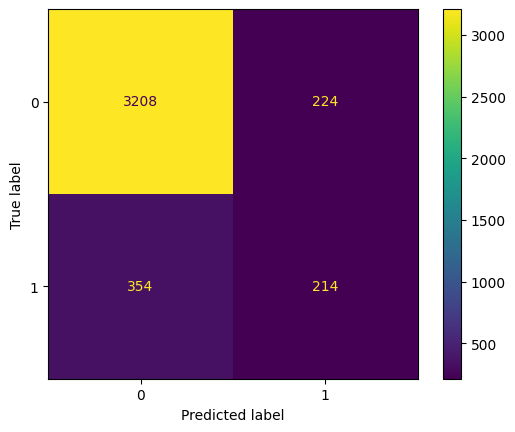

In [178]:
model_name = "SMOTE_knn_df"
best_xgb_classifier, grid_search_results_df, model_results_df = perform_full_xgb_workflow(X_train_resampled, y_train_resampled, X_test, y_test, gbm_param_for_boosting, gbm_param_grid_for_tunning_fixed, fone_scorer, model_name,eval_metric,  early_stopping_rounds=early_stopping_rounds, n_estimators=num_boosting_rounds, cross_validation_folds=cross_validation_folds,  resampling_technique = "SMOTE")
all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

### 2.1.4 XgBooSt performed With Random Oversampling

In [179]:
# Instantiate RandomOverSampler
oversampler = RandomOverSampler(random_state=RANDOM_STATE)
# Fit RandomOverSampler to your training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)


TRainingparameterS [1]
Optimal number of boosting rounds: 83
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      3432
           1       0.39      0.72      0.50       568

    accuracy                           0.80      4000
   macro avg       0.67      0.77      0.69      4000
weighted avg       0.87      0.80      0.82      4000



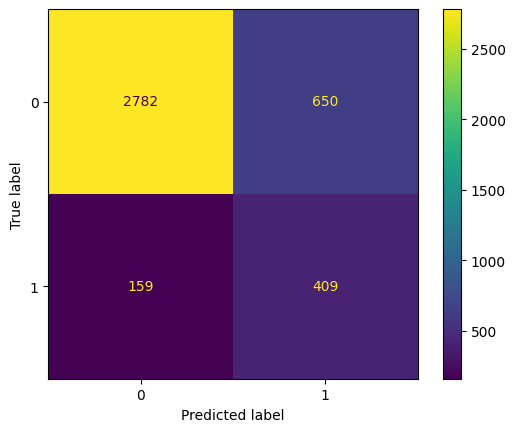

In [180]:
model_name = "ROS_knn_df"
best_xgb_classifier, grid_search_results_df, model_results_df = perform_full_xgb_workflow(X_train_resampled, y_train_resampled, X_test, y_test, gbm_param_for_boosting, gbm_param_grid_for_tunning_fixed, fone_scorer, model_name, eval_metric, early_stopping_rounds=early_stopping_rounds, n_estimators=num_boosting_rounds, cross_validation_folds=cross_validation_folds,  resampling_technique = "Oversampling")
all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

### 2.1.5 XgBooSt performed With Random Undersampling

In [181]:
# Instantiate RandomUnderSampler
undersampler = RandomUnderSampler(random_state=RANDOM_STATE)
# Fit RandomUnderSampler to your training data
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


TRainingparameterS [1]
Optimal number of boosting rounds: 105
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80      3432
           1       0.28      0.72      0.40       568

    accuracy                           0.70      4000
   macro avg       0.61      0.71      0.60      4000
weighted avg       0.84      0.70      0.74      4000



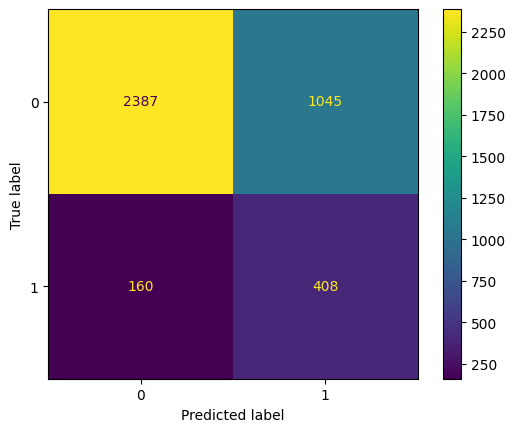

In [182]:
model_name = "RUS_knn_df"
best_xgb_classifier, grid_search_results_df, model_results_df = perform_full_xgb_workflow(X_train_resampled, y_train_resampled, X_test, y_test, gbm_param_for_boosting, gbm_param_grid_for_tunning_fixed, fone_scorer, model_name, eval_metric,  early_stopping_rounds=early_stopping_rounds, n_estimators=num_boosting_rounds, cross_validation_folds=cross_validation_folds,  resampling_technique = "Undersampling")
all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

###############################################

### 3.1 Using -1 inputed NAN file

In [183]:
#loading dataframe
minus1_df = pd.read_csv(os.path.join(file_path_to_save, 'minus1_imputed_df.csv')) 

In [184]:
pd.options.display.max_columns = None
minus1_df.sample()


,RecordID,Age,Gender,ICUType,BMI,MechVent,BUN_median,BUN_mad,BUN_slope,Creatinine_median,Creatinine_mad,FiO2_median,FiO2_max,FiO2_mad,GCS_median,GCS_mad,Glucose_48median,Glucose_median,Glucose_max,Glucose_mad,Glucose_slope,HCO3_median,HCO3_mad,HCT_median,HCT_mad,HR_median,HR_max,HR_mad,HR_slope,K_48median,K_median,K_max,K_mad,Lactate_median,Lactate_mad,Mg_48median,Mg_median,Mg_max,Mg_mad,MAP_median,MAP_max,MAP_mad,MAP_last,MAP_slope,Na_median,Na_mad,Na_slope,NIMAP_median,NIMAP_max,NIMAP_mad,NIMAP_last,NIMAP_slope,PaCO2_median,PaCO2_max,PaCO2_mad,PaCO2_slope,PaO2_48median,PaO2_median,PaO2_max,PaO2_mad,PaO2_slope,pH_median,pH_mad,Platelets_median,Platelets_mad,Platelets_slope,Temp_median,Temp_max,Temp_mad,Temp_last,Urine_median,Urine_max,Urine_mad,Urine_last,Urine_slope,WBC_median,WBC_mad,WBC_slope,Weight_24median,Weight_mad,Weight_slope,Length_of_stay,In-hospital_death
410,133585.0,60.0,0,4,18.342152,1,22.0,4.545455,0.189189,0.6,0.0,0.5,0.5,0.0,15.0,0.0,131.0,133.0,171.0,6.015038,-0.516129,32.0,6.25,28.7,3.484321,67.0,168.0,22.38806,0.426183,3.6,3.65,4.5,1.369863,2.3,47.826087,2.1,2.1,2.1,0.0,80.5,103.0,6.832298,85.0,0.016818,140.0,0.0,1.172657e-15,-1.0,-1.0,-1.0,-1.0,-1.0,46.0,49.0,4.347826,-0.158635,167.0,171.0,183.0,5.263158,0.076305,7.475,0.334448,128.5,2.33463,-0.047619,37.4,37.7,0.534759,37.3,75.0,220.0,33.333333,80.0,0.795665,9.0,2.777778,-0.077735,45.5,0.0,-1.0,19,0


In [185]:
minus1_df.shape


(12000, 83)

In [186]:
# Convert the specified columns to categorical type
minus1_df[categorical_features] = minus1_df[categorical_features].astype("category")


<b> Preparing test-train datasets </b>
- X = training data with all features except target variable 
- y = target variable "In-hospital_death" 
- Drop "Length_of_stay" and use "RecordID"  as index 

In [187]:
minus1_df = minus1_df.drop(columns=['In-hospital_death', 'Length_of_stay'])
minus1_outcomes_a_df = pd.merge(minus1_df, outcomes_a, on="RecordID", how="inner")
minus1_outcomes_b_df = pd.merge(minus1_df, outcomes_b, on="RecordID", how="inner")
minus1_outcomes_c_df = pd.merge(minus1_df, outcomes_c, on="RecordID", how="inner")

In [188]:
# Extract features and target variable
# For training set X_train and y_train
X_a = knn_outcomes_a_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
y_a = knn_outcomes_a_df['In-hospital_death']

# For testing set B X_test_b and y_test_b
X_b = knn_outcomes_b_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
y_b = knn_outcomes_b_df['In-hospital_death']

# For testing set C X_test_c and y_test_c
X_c = knn_outcomes_c_df.drop(columns=['In-hospital_death', 'Length_of_stay', 'RecordID'])
y_c = knn_outcomes_c_df['In-hospital_death']

# Define a dictionary to store the splits
data_splits = {'_a': (X_a, y_a), '_b': (X_b, y_b), '_c': (X_c, y_c)}

# Get the selected splits for training and testing
X_train, y_train = data_splits[choice_train]
X_test, y_test = data_splits[choice_test]

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4000, 80)
X_test shape: (4000, 80)
y_train shape: (4000,)
y_test shape: (4000,)


### 3.1.1 XgBooSt performed Without PCA 

TRainingparameterS [2.4555807820458484]
Optimal number of boosting rounds: 53
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3432
           1       0.51      0.44      0.47       568

    accuracy                           0.86      4000
   macro avg       0.71      0.69      0.70      4000
weighted avg       0.85      0.86      0.86      4000



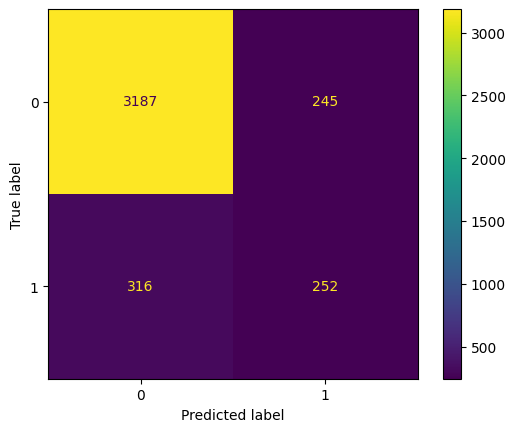

In [189]:
# run method to perfrom xgb workflow
model_name = "m1_df"
best_xgb_classifier, grid_search_results_df, model_results_df = perform_full_xgb_workflow(X_train, y_train, X_test, y_test, gbm_param_for_boosting, gbm_param_grid_for_tunning_fixed, fone_scorer, model_name, eval_metric, early_stopping_rounds=early_stopping_rounds, n_estimators=num_boosting_rounds, cross_validation_folds=cross_validation_folds)
all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

### 3.1.2 XgBooSt performed With PCA 

<b> Perform PCA </b>

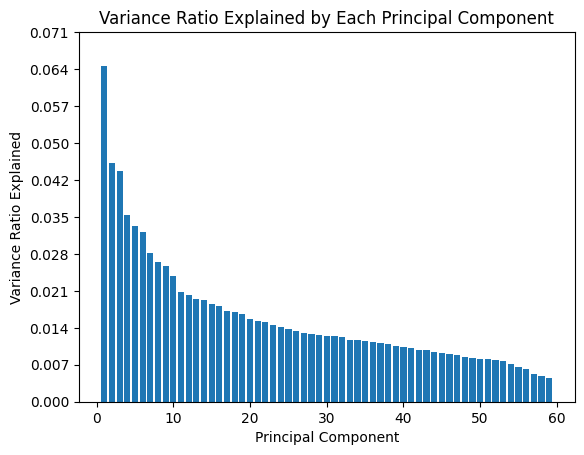

Number of components required to achieve 0.95 variance explained: 59


In [190]:
X_train_PCA, X_test_PCA, pca, explained_variance_ratio = perform_pca (X_train, X_test, categorical_features, 0.95)

TRainingparameterS [2.4555807820458484]
Optimal number of boosting rounds: 208
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      3432
           1       0.48      0.44      0.46       568

    accuracy                           0.85      4000
   macro avg       0.69      0.68      0.69      4000
weighted avg       0.85      0.85      0.85      4000



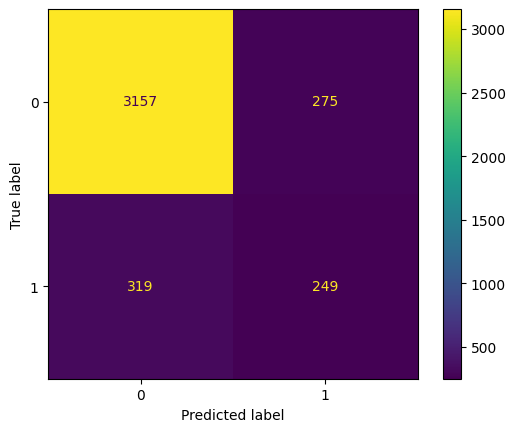

In [191]:
# run method to perfrom xgb workflow
model_name = "PCA_m1_df"
best_xgb_classifier, grid_search_results_df, model_results_df = perform_full_xgb_workflow(X_train_PCA, y_train, X_test_PCA, y_test, gbm_param_for_boosting, gbm_param_grid_for_tunning_fixed, fone_scorer, model_name, eval_metric, early_stopping_rounds=early_stopping_rounds, n_estimators=num_boosting_rounds, cross_validation_folds=cross_validation_folds)
all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

### 3.1.3 XgBooSt performed With SMOTE

In [192]:
#permorm SMOTE
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors = 5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

TRainingparameterS [1]
Optimal number of boosting rounds: 133
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      3432
           1       0.49      0.38      0.43       568

    accuracy                           0.86      4000
   macro avg       0.69      0.66      0.67      4000
weighted avg       0.84      0.86      0.85      4000



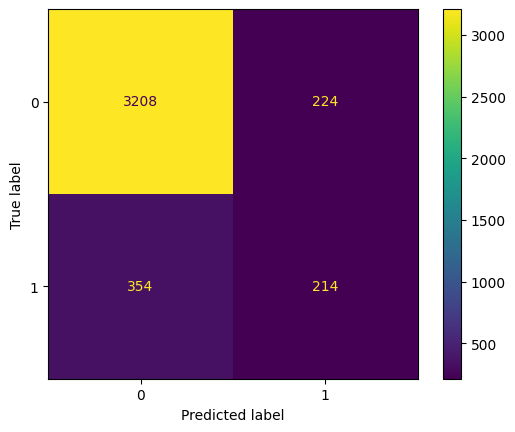

In [193]:
model_name = "SMOTE_m1_df"
best_xgb_classifier, grid_search_results_df, model_results_df = perform_full_xgb_workflow(X_train_resampled, y_train_resampled, X_test, y_test, gbm_param_for_boosting, gbm_param_grid_for_tunning_fixed, fone_scorer, model_name, eval_metric, early_stopping_rounds=early_stopping_rounds, n_estimators=num_boosting_rounds, cross_validation_folds=cross_validation_folds,  resampling_technique = "SMOTE")
all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

### 3.1.4 XgBooSt performed With RamdonOversampling

In [194]:
# Instantiate RandomOverSampler
oversampler = RandomOverSampler(random_state=RANDOM_STATE)
# Fit RandomOverSampler to your training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)


TRainingparameterS [1]
Optimal number of boosting rounds: 83
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      3432
           1       0.39      0.72      0.50       568

    accuracy                           0.80      4000
   macro avg       0.67      0.77      0.69      4000
weighted avg       0.87      0.80      0.82      4000



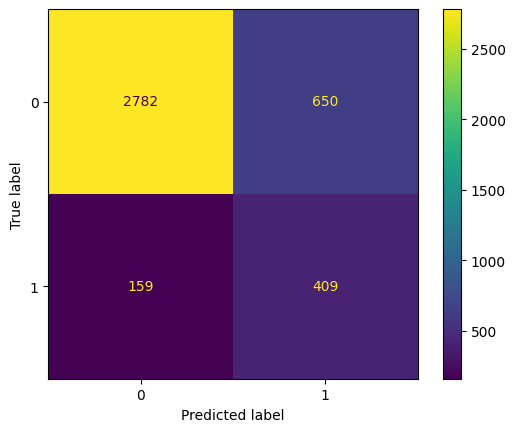

In [195]:
model_name = "ROS_m1_df"
best_xgb_classifier, grid_search_results_df, model_results_df = perform_full_xgb_workflow(X_train_resampled, y_train_resampled, X_test, y_test, gbm_param_for_boosting, gbm_param_grid_for_tunning_fixed, fone_scorer, model_name, eval_metric,  early_stopping_rounds=early_stopping_rounds, n_estimators=num_boosting_rounds, cross_validation_folds=cross_validation_folds,  resampling_technique = "Oversampling")
all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

### 3.1.5 XgBooSt performed With RamdonUndersampling

In [196]:
# Instantiate RandomUnderSampler
undersampler = RandomUnderSampler(random_state=RANDOM_STATE)
# Fit RandomUnderSampler to your training data
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


TRainingparameterS [1]
Optimal number of boosting rounds: 105
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80      3432
           1       0.28      0.72      0.40       568

    accuracy                           0.70      4000
   macro avg       0.61      0.71      0.60      4000
weighted avg       0.84      0.70      0.74      4000



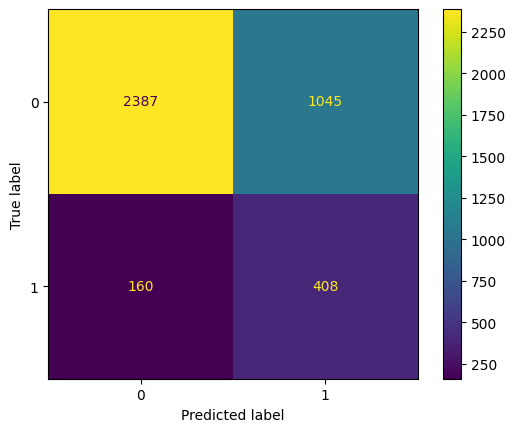

In [197]:
model_name = "RUS_m1_df"
best_xgb_classifier, grid_search_results_df, model_results_df = perform_full_xgb_workflow(X_train_resampled, y_train_resampled, X_test, y_test, gbm_param_for_boosting, gbm_param_grid_for_tunning_fixed, fone_scorer, model_name, eval_metric, early_stopping_rounds=early_stopping_rounds, n_estimators=num_boosting_rounds, cross_validation_folds=cross_validation_folds,  resampling_technique = "Undersampling")
all_results_df = pd.concat([model_results_df, all_results_df], ignore_index=True)
all_grid_results_df  = pd.concat([grid_search_results_df, all_grid_results_df], ignore_index=True)

## Evaluate models results

In [198]:

sorted_all_grid_results_df = all_grid_results_df.sort_values(by='Cvalidation_test_score', ascending=False)
sorted_all_grid_results_df

,Model,Method,params,Cvalidation_test_score,std_Cvalidation_score
2,XGBoost,SMOTE_m1_df,"{'colsample_bytree': 0.7, 'gamma': 0.01, 'lear...",0.903198,0.004527
7,XGBoost,SMOTE_knn_df,"{'colsample_bytree': 0.7, 'gamma': 0.01, 'lear...",0.903198,0.004527
1,XGBoost,ROS_m1_df,"{'colsample_bytree': 0.7, 'gamma': 0.01, 'lear...",0.836666,0.010669
6,XGBoost,ROS_knn_df,"{'colsample_bytree': 0.7, 'gamma': 0.01, 'lear...",0.836666,0.010669
4,XGBoost,m1_df,"{'colsample_bytree': 0.7, 'gamma': 0.01, 'lear...",0.422349,0.053825
9,XGBoost,knn_df,"{'colsample_bytree': 0.7, 'gamma': 0.01, 'lear...",0.422349,0.053825
3,XGBoost,PCA_m1_df,"{'colsample_bytree': 0.7, 'gamma': 0.01, 'lear...",0.399601,0.042777
8,XGBoost,PCA_knn_df,"{'colsample_bytree': 0.7, 'gamma': 0.01, 'lear...",0.399601,0.042777
0,XGBoost,RUS_m1_df,"{'colsample_bytree': 0.7, 'gamma': 0.01, 'lear...",0.384463,0.313972
5,XGBoost,RUS_knn_df,"{'colsample_bytree': 0.7, 'gamma': 0.01, 'lear...",0.384463,0.313972


In [199]:
#Final model results sorted by the minimum between precision and recall
# Compute the minimum value between Precision and Recall
all_results_df['Min_Precision_Recall'] = all_results_df[['Precision', 'Recall']].min(axis=1)

# Sort the DataFrame by the 'Min_Precision_Recall' column in descending order
sorted_results_df = all_results_df.sort_values(by='Min_Precision_Recall', ascending=False)


sorted_results_df

,Model,Method,Precision,Recall,F1-Score,PRAUC,Min_Precision_Recall
4,Xgcboost,m1_df,0.507042,0.443662,0.473239,0.485777,0.443662
9,Xgcboost,knn_df,0.507042,0.443662,0.473239,0.485777,0.443662
3,Xgcboost,PCA_m1_df,0.475191,0.438380,0.456044,0.458220,0.438380
8,Xgcboost,PCA_knn_df,0.475191,0.438380,0.456044,0.458220,0.438380
1,Xgcboost,ROS_m1_df,0.386213,0.720070,0.502766,0.488581,0.386213
6,Xgcboost,ROS_knn_df,0.386213,0.720070,0.502766,0.488581,0.386213
2,Xgcboost,SMOTE_m1_df,0.488584,0.376761,0.425447,0.460856,0.376761
7,Xgcboost,SMOTE_knn_df,0.488584,0.376761,0.425447,0.460856,0.376761
0,Xgcboost,RUS_m1_df,0.280798,0.718310,0.403761,0.353514,0.280798
5,Xgcboost,RUS_knn_df,0.280798,0.718310,0.403761,0.353514,0.280798
